In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [4]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [12]:
class gPINN:
    def __init__(self, x, t, D, layers, activation, lr, w_g):
        self.x = x
        self.t = t
        self.D = D
        self.lr = lr
        self.activation = activation
        self.w_g = w_g
        self.loss_log = []

        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])

        self.surrogate_u = self.surrogate(self.x_tf, self.t_tf)
        self.residual    = self.residual_net(self.surrogate_u, self.x_tf, self.t_tf)
        self.loss_res    = tf.reduce_mean(tf.square(self.residual))
        self.loss_der_x  = tf.reduce_mean(tf.square(self.resi_der_x(self.residual, self.x_tf)))
        self.loss_der_t  = tf.reduce_mean(tf.square(self.resi_der_t(self.residual, self.t_tf)))
        self.loss        = self.loss_res + self.w_g * self.loss_der_t + self.w_g * self.loss_der_x

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases, self.activation)
        return u

    def surrogate(self, x, t):
        rhs = tf.sin(8*x) / 8
        for i in range(1, 5):
            rhs += tf.sin(i*x) / i
        return (x**2 - np.pi**2)*(1-np.e**-t)*self.net_u(x, t) + rhs

    def R(self, x, t):
        return np.e**(-t)*(3/2*tf.sin(2*x)+8/3*tf.sin(3*x)+15/4*tf.sin(4*x)+63/8*tf.sin(8*x))

    def residual_net(self, u, x, t):
        u_x  = tf.gradients(u, x)[0]
        u_t  = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        return u_t - self.D*u_xx - self.R(x, t)

    def resi_der_x(self, res, x):
        res_x = tf.gradients(res, x)[0]
        return res_x

    def resi_der_t(self, res, t):
        res_t = tf.gradients(res, t)[0]
        return res_t

    def callback(self, loss, res, deriv):
        print('Loss:%f,res:%f,deriv:%f'%(loss, res, deriv))

    def train(self, max_iter=40000):
        loss_value = np.inf
        for iter in range(max_iter):
            tf_dict = {
                self.x_tf:self.x,
                self.t_tf:self.t
            }
            _, loss_value, lres, lder_x, lder_t = self.sess.run([self.optimizer,
                self.loss, self.loss_res, self.loss_der_x, self.loss_der_t], tf_dict)
            self.loss_log.append(loss_value)
            if iter % 1000 == 0:
                print("第%d次 %f,res %f,rdx %f,rdt %f"%(iter, loss_value, lres, lder_x, lder_t))
        print("第%d次的损失为%f"%(max_iter, loss_value))

    def predict(self, X_star, T_star):
        u_star = self.sess.run(self.surrogate_u, {self.x_tf: X_star, self.t_tf:T_star})
        return u_star

In [30]:
layers = [2, 20, 20, 20, 20, 1]
activation = tf.tanh
lr = 1e-4
iterations = 100000
D = 1
w_g = 0.1

In [12]:
def train_model(train_num):
    x = np.linspace(-np.pi, np.pi, train_num)[:, None]
    t = np.linspace(0, 1, train_num)[:, None]
    X, T = np.meshgrid(x, t)
    x = X.flatten()[:, None]
    t = T.flatten()[:, None]
    start_time = time.time()
    gPINN_tanh = gPINN(x, t, D, layers, activation, lr, w_g)
    print("Start training! train_num:%d"%(train_num))
    gPINN_tanh.train(iterations)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return gPINN_tanh

In [13]:
def compute_error(model, test_num):
    x_test = np.linspace(-np.pi, np.pi, test_num)[:, None]
    t_test = np.linspace(0, 1, test_num)[:, None]
    X, T = np.meshgrid(x_test, t_test)
    x_test = X.flatten()[:, None]
    t_test = T.flatten()[:, None]
    u_test  = np.sin(8*x_test)/8
    for i in range(1, 5):
        u_test += np.sin(i*x_test) / i
    u_test  *= np.e**(-t_test)
    u_pred   = model.predict(x_test, t_test)
    L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    return L2_norm

In [1]:
train_nums = np.array([5, 6, 7, 8, 9, 10, 11])
test_num   = 100
errors     = []
for train_num in train_nums:
    model = train_model(train_num)
    error = compute_error(model, test_num)
    print("train_num:%d, error:%f"%(train_num, error))
    errors.append(error)
errors = np.array(errors)
np.save('errors_gPINN.npy', errors)

NameError: name 'np' is not defined

In [31]:
x = np.linspace(-np.pi, np.pi, 10)[:, None]
t = np.linspace(0, 1, 5)[:, None]
X, T = np.meshgrid(x, t)
x = X.flatten()[:, None]
t = T.flatten()[:, None]
start_time = time.time()
gPINN_tanh = gPINN(x, t, D, layers, activation, lr, w_g)
print("Start training!")
gPINN_tanh.train(iterations)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

Start training!
第0次 66.874664,res 24.858837,rdx 401.796600,rdt 18.361670
第1000次 39.166367,res 3.909839,rdx 340.101440,rdt 12.463863
第2000次 30.875332,res 6.123712,rdx 234.158463,rdt 13.357743
第3000次 15.508022,res 3.157445,rdx 116.270607,rdt 7.235166
第4000次 7.639418,res 1.443105,rdx 57.421143,rdt 4.541977
第5000次 4.164549,res 1.270495,rdx 26.208618,rdt 2.731920
第6000次 1.396277,res 0.232312,rdx 9.223896,rdt 2.415756
第7000次 0.530173,res 0.073338,rdx 2.674698,rdt 1.893654
第8000次 0.295552,res 0.036622,rdx 1.177539,rdt 1.411759
第9000次 0.191745,res 0.021555,rdx 0.612518,rdt 1.089382
第10000次 0.139265,res 0.014800,rdx 0.370490,rdt 0.874162
第11000次 0.149705,res 0.019598,rdx 0.530053,rdt 0.771013
第12000次 0.090351,res 0.009371,rdx 0.192505,rdt 0.617287
第13000次 0.076709,res 0.007922,rdx 0.156600,rdt 0.531271
第14000次 0.066328,res 0.006694,rdx 0.134297,rdt 0.462044
第15000次 0.058223,res 0.005790,rdx 0.119817,rdt 0.404517
第16000次 0.055260,res 0.006492,rdx 0.133596,rdt 0.354076
第17000次 0.046179,res 0.0044

In [32]:
x_num = 400
t_num = 200
x_test = np.linspace(-np.pi, np.pi, x_num)[:, None]
t_test = np.linspace(0, 1, t_num)[:, None]
X, T = np.meshgrid(x_test, t_test)
x_test = X.flatten()[:, None]
t_test = T.flatten()[:, None]
u_test  = np.sin(8*x_test)/8
for i in range(1, 5):
    u_test += np.sin(i*x_test) / i
u_test  *= np.e**(-t_test)

In [33]:
# t -> [0, 1] : x -> [-pi, pi]
u_pred = gPINN_tanh.predict(x_test, t_test)
L2_norm  = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
print(L2_norm)

1.512920040156387


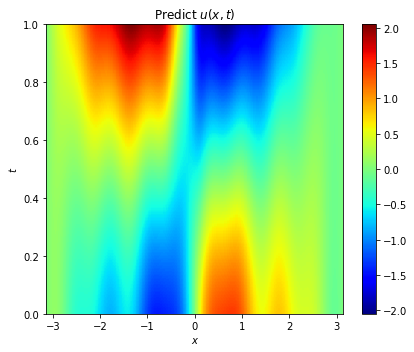

In [34]:
u_test = np.reshape(u_test, (t_num, x_num))
u_pred = np.reshape(u_pred, (t_num, x_num))
fig = plt.figure(figsize=(6,5))
plt.pcolor(X, T, u_pred, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('Pred s gPINN.pdf')

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.pcolor(X, T, u_test, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.colorbar()
plt.tight_layout()
# plt.savefig('Exact s.pdf')
